In [53]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
# from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import wandb
import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder

from sklearn.metrics import accuracy_score
import gc

import sys 
sys.path.append('/home/pengq/speech_recognition')

import importlib

import models.ASR
import models.utils
import scripts.trainer
import scripts.train_val
importlib.reload(models.ASR) 
importlib.reload(models.utils) 
importlib.reload(scripts.trainer) 
importlib.reload(scripts.train_val) 

from scripts.data_prep import AudioDataset
from models.ASR import ASRModel, initialize_weights
from scripts.train_val import calculate_levenshtein
from scripts.trainer import Trainer

import glob

import zipfile
from tqdm.auto import tqdm
import os
import datetime


import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


# Setup Vocabulary

In [54]:
config = {
    "subset": 0.1, 
    "epochs": 100,
    "batch_size": 128, 
    "augmentations": "TimeMask", 
    "time_mask_param": 100, 
    "freq_mask_param": 10,
    "mfcc_features": 28,

    "lr": 0.001,
    "weight_decay": 1e-5,
    "pct_start": 0.25,
    "train_beam_width": 3,
    "test_beam_width": 10,

    "embed_size": 256, 
    "cnn_arch": [[128, 3, 1, 1], [256, 3, 1, 1], [512, 3, 1, 1]],
    "linear_arch": [[1024, 0.2], [2048, 0.2], [1024, 0.2], [512, 0.2]],
    "num_pBLSTM": 2,
    "encoder_dropout": 0.2,
    "lstm_dropout": 0.2,
    "decoder_dropout": 0.2,
    "input_size": 28,

    "save_every": 2, 
}

In [55]:
CMUdict_ARPAbet = {
    "" : " ",
    "[SIL]": "-", "NG": "G", "F" : "f", "M" : "m", "AE": "@",
    "R"    : "r", "UW": "u", "N" : "n", "IY": "i", "AW": "W",
    "V"    : "v", "UH": "U", "OW": "o", "AA": "a", "ER": "R",
    "HH"   : "h", "Z" :
     "z", "K" : "k", "CH": "C", "W" : "w",
    "EY"   : "e", "ZH": "Z", "T" : "t", "EH": "E", "Y" : "y",
    "AH"   : "A", "B" : "b", "P" : "p", "TH": "T", "DH": "D",
    "AO"   : "c", "G" : "g", "L" : "l", "JH": "j", "OY": "O",
    "SH"   : "S", "D" : "d", "AY": "Y", "S" : "s", "IH": "I",
    "[SOS]": "[SOS]", "[EOS]": "[EOS]"
}


CMUdict = list(CMUdict_ARPAbet.keys())
ARPAbet = list(CMUdict_ARPAbet.values())

PHONEMES = CMUdict[:-2]     #To be used for mapping original transcripts to integer indices
LABELS = ARPAbet[:-2]       #To be used for mapping predictions to strings

OUT_SIZE = len(PHONEMES)    # Number of output classes
print("Number of Phonemes:", OUT_SIZE)

# Indexes of BLANK and SIL phonemes
BLANK_IDX=CMUdict.index('')
SIL_IDX=CMUdict.index('[SIL]')

print("Index of Blank:", BLANK_IDX)
print("Index of [SIL]:", SIL_IDX)

Number of Phonemes: 41
Index of Blank: 0
Index of [SIL]: 1


### Sample data inspection & sanity check

In [56]:
root = "/data/user_data/pengq/11785-S25-hw3p2"

test_mfcc = f"{root}/train-clean-100/mfcc/103-1240-0000.npy"
test_transcript = f"{root}/train-clean-100/transcript/103-1240-0000.npy"

mfcc = np.load(test_mfcc)
transcript = np.load(test_transcript)[1:-1] #Removed [SOS] and [EOS]

print("MFCC Shape:", mfcc.shape)
print("\nMFCC:\n", mfcc)
print("\nTranscript shape:", transcript.shape)

print("\nOriginal Transcript:\n", transcript)

# map the loaded transcript (from phonemes representation) to corresponding labels representation
mapped_transcript = [CMUdict_ARPAbet[k] for k in transcript]
print("\nTranscript mapped from PHONEMES representation to LABELS representation:\n", mapped_transcript)

# Mapping list of PHONEMES to list of Integer indexes
map = {k: i for i, k in enumerate(PHONEMES)}
print("\nMapping list of PHONEMES to list of Integer indexes:\n", map)

MFCC Shape: (1404, 28)

MFCC:
 [[ 1.10582151e+01  1.28330450e+01  2.10689220e+01 ... -8.75406042e-02
   7.30623007e-02  9.48924713e+01]
 [ 1.16850815e+01  1.38329487e+01  2.19087906e+01 ... -1.39180899e-01
  -6.15991093e-02  9.55670319e+01]
 [ 1.11048431e+01  1.67276516e+01  2.28863831e+01 ... -4.03698802e-01
   8.09250996e-02  9.54314651e+01]
 ...
 [ 2.62413955e+00 -1.26996317e+01  2.79472313e+01 ... -1.49060452e+00
  -2.67574161e-01  1.16191261e+02]
 [ 3.05713993e-02 -1.20763254e+01  2.60116520e+01 ... -8.54688883e-01
  -1.20284989e-01  1.17127373e+02]
 [-1.33604801e+00 -1.17101593e+01  2.44703121e+01 ... -9.30283189e-01
  -8.16672146e-02  1.18280014e+02]]

Transcript shape: (145,)

Original Transcript:
 ['[SIL]' 'CH' 'AE' 'P' 'T' 'ER' 'W' 'AH' 'N' '[SIL]' 'M' 'IH' 'S' 'IH' 'Z'
 'R' 'EY' 'CH' 'AH' 'L' 'IH' 'N' 'D' 'IH' 'Z' 'S' 'ER' 'P' 'R' 'AY' 'Z'
 'D' '[SIL]' 'M' 'IH' 'S' 'IH' 'Z' 'R' 'EY' 'CH' 'AH' 'L' 'IH' 'N' 'D'
 '[SIL]' 'L' 'AY' 'V' 'D' '[SIL]' 'JH' 'AH' 'S' 'T' 'W' 'EH' 'R' '

# Dataset and Dataloader

### Load Data

In [57]:
import gc
gc.collect()

1139

In [58]:
# Create objects for the dataset classes
train_data = AudioDataset(root=root, PHONEMES=PHONEMES, partition="train-clean-100", config=config)
val_data = AudioDataset(root=root, PHONEMES=PHONEMES, partition="dev-clean", config=config)
test_data = AudioDataset(root=root, PHONEMES=PHONEMES, partition="test-clean", config=config, load_transcript=False, test=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 262/262 [00:34<00:00,  7.65it/s]


In [7]:
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 10,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True,
    collate_fn = train_data.collate_fn
) 

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 10,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False,
    collate_fn=val_data.collate_fn
) 

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    num_workers=10,
    batch_size=config['batch_size'],
    pin_memory=True,
    collate_fn=test_data.collate_fn,
    shuffle=False
)

print("Batch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  128
Train dataset samples = 2853, batches = 23
Val dataset samples = 270, batches = 3
Test dataset samples = 262, batches = 3


In [8]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

torch.Size([128, 1663, 28]) torch.Size([128, 216]) torch.Size([128]) torch.Size([128])


# Visualize Data

In [ ]:
import matplotlib.pyplot as plt

def visualize_batch(loader, title="Dataset Visualization", num_samples=2):
    """
    Visualizes MFCC features from a single batch of data.

    Args:
        loader (DataLoader): DataLoader object (for train, val, or test).
        title (str): Title of the plot.
        num_samples (int): Number of samples to visualize from the batch.
    """
    # Get one batch from the loader.
    batch = next(iter(loader))

    # The collate_fn we defined in the dataset class returns a tuple, where the first element is the padded MFCC tensor.
    mfcc_batch = batch[0] if isinstance(batch, (tuple, list)) else batch

    # Limit to a few samples.
    num_samples = min(num_samples, mfcc_batch.size(0))

    # Create subplots.
    fig, axes = plt.subplots(1, num_samples, figsize=(15,6))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        # Each MFCC tensor is of shape [time, frequency].
        # Transpose for visualization: time on x-axis, features on y-axis.
        mfcc_img = mfcc_batch[i].cpu().numpy().T
        im = axes[i].imshow(mfcc_img, origin="lower", aspect="auto", cmap="viridis")
        axes[i].set_title(f"Sample {i}")
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("MFCC Coefficient")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize batches of data
visualize_batch(train_loader, title="Training Dataset MFCCs (with Time & Frequency Masking)")


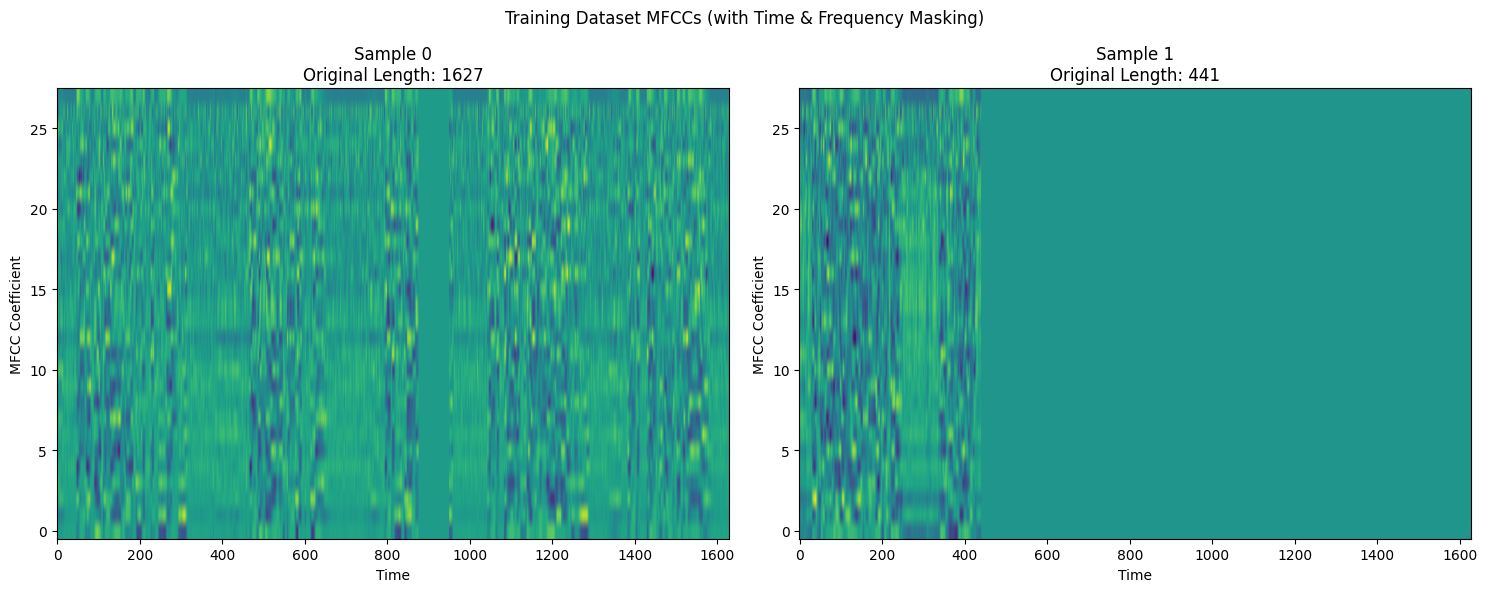

In [9]:
import matplotlib.pyplot as plt

def visualize_batch(loader, title="Dataset Visualization", num_samples=2):
    """
    Visualizes MFCC features from a single batch of data and prints original lengths.

    Args:
        loader (DataLoader): DataLoader object (for train, val, or test).
        title (str): Title of the plot.
        num_samples (int): Number of samples to visualize from the batch.
    """
    # Get one batch from the loader.
    batch = next(iter(loader))

    # The collate_fn returns:
    # (mfcc_batch_pad, transcript_pad, mfcc_lengths, transcript_lengths)
    mfcc_batch = batch[0]
    mfcc_lengths = batch[2]

    # Limit to a few samples.
    num_samples = min(num_samples, mfcc_batch.size(0))

    # Create subplots.
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 6))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        # Transpose: [time, freq] -> [freq, time] for imshow
        mfcc_img = mfcc_batch[i].cpu().numpy().T
        im = axes[i].imshow(mfcc_img, origin="lower", aspect="auto", cmap="viridis")
        axes[i].set_title(f"Sample {i}\nOriginal Length: {mfcc_lengths[i].item()}")
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("MFCC Coefficient")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
visualize_batch(train_loader, title="Training Dataset MFCCs (with Time & Frequency Masking)")


# Network

## ASR Network

In [9]:
model = ASRModel(
    cnn_arch = config["cnn_arch"], 
    input_size = config["input_size"], 
    encoder_hidden_size = config["embed_size"], 
    num_pBLSTM = config["num_pBLSTM"], 
    linear_arch = config["linear_arch"], 
    embed_size = config["embed_size"], 
    encoder_dropout = config["encoder_dropout"], 
    decoder_dropout = config["decoder_dropout"]
).to(device)

model_name = "ASR"

In [10]:
model.apply_init(x.to(device), lx.to(device), initialize_weights)

In [11]:
summary(model, input_data=[x.to(device), lx.to(device)])

Layer (type:depth-idx)                   Output Shape              Param #
ASRModel                                 [128, 415, 41]            --
├─Encoder: 1-1                           [128, 415, 512]           --
│    └─Sequential: 2-1                   [128, 512, 1663]          --
│    │    └─Conv1d: 3-1                  [128, 128, 1663]          10,880
│    │    └─BatchNorm1d: 3-2             [128, 128, 1663]          256
│    │    └─GELU: 3-3                    [128, 128, 1663]          --
│    │    └─Conv1d: 3-4                  [128, 256, 1663]          98,560
│    │    └─BatchNorm1d: 3-5             [128, 256, 1663]          512
│    │    └─GELU: 3-6                    [128, 256, 1663]          --
│    │    └─Conv1d: 3-7                  [128, 512, 1663]          393,728
│    │    └─BatchNorm1d: 3-8             [128, 512, 1663]          1,024
│    │    └─GELU: 3-9                    [128, 512, 1663]          --
│    └─LSTMWrapper: 2-2                  [157435, 512]             

In [ ]:
model.apply_init(x.to(device), lx.to(device), initialize_weights)
criterion = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
decoder = cuda_ctc_decoder(tokens=LABELS, nbest=1, beam_size=config["train_beam_width"])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["lr"], 
        total_steps = config["epochs"] * len(train_loader), 
        pct_start = config["pct_start"], 
        anneal_strategy="cos"
    )

scaler = torch.cuda.amp.GradScaler()

torch.cuda.empty_cache()
gc.collect()

start=0

## Test Implementation

In [61]:
# test code to check shapes

model.eval()
for i, data in enumerate(val_loader, 0):
    x, y, lx, ly = data
    x, y = x.to(device), y.to(device)
    lx, ly = lx.to(device), ly.to(device)
    h, lh = model(x, lx)
    print(h.shape)
    h = torch.permute(h, (1, 0, 2))
    print(h.shape, y.shape)
    loss = criterion(h, y, lh, ly)
    print(loss)

    print(calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh.to(device), ly, decoder, LABELS))

    del x, y, lx, ly, h, lh, loss
    torch.cuda.empty_cache()

    break

torch.Size([128, 734, 41])
torch.Size([734, 128, 41]) torch.Size([128, 265])
tensor(6.8415, device='cuda:0', grad_fn=<MeanBackward0>)
59.2734375


In [13]:
wandb.login(key="232fdceeae8cfc797a73cea836fb0c4a6199a7ae")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/pengq/.netrc
wandb: Currently logged in as: peng_qiu (MIC-Research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [14]:
name = f"{model_name}_run.1"

In [52]:
# For test
wandb.unwatch(model)
test_Trainer = Trainer(config["epochs"], criterion, optimizer, decoder, scheduler, LABELS,
                       config["save_every"], name, device=device, scaler=scaler, checkpoint_dir="/data/user_data/pengq/speech")
test_Trainer.fit(model, train_loader, val_loader, log_epoch=False, log_batch=False, save_best=False,
                 checkpoints=False)

wandb: WARNING ASRModel(
wandb: WARNING   (encoder): Encoder(
wandb: WARNING     (embedding): Sequential(
wandb: WARNING       (0): Conv1d(28, 128, kernel_size=(3,), stride=(1,), padding=(1,))
wandb: WARNING       (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
wandb: WARNING       (2): GELU(approximate='none')
wandb: WARNING       (3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
wandb: WARNING       (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
wandb: WARNING       (5): GELU(approximate='none')
wandb: WARNING       (6): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
wandb: WARNING       (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
wandb: WARNING       (8): GELU(approximate='none')
wandb: WARNING     )
wandb: WARNING     (BLSTMs): LSTMWrapper(
wandb: WARNING       (lstm): LSTM(512, 256, num_layers=2, bidirectional=True)
wandb: WARNING  


Epoch 1/100


	Train Loss 3.3761	 Learning Rate 0.0000738
	Val Dist 55.5580	 Val Loss 3.9100

Epoch 2/100


	Train Loss 3.2503	 Learning Rate 0.0000996
	Val Dist 55.6194	 Val Loss 3.2253

Epoch 3/100


	Train Loss 3.0967	 Learning Rate 0.0001320
	Val Dist 54.8594	 Val Loss 2.9271

Epoch 4/100


	Train Loss 2.9344	 Learning Rate 0.0001705
	Val Dist 50.5521	 Val Loss 2.7224

Epoch 5/100


	Train Loss 2.7513	 Learning Rate 0.0002146
	Val Dist 46.0078	 Val Loss 2.4634

Epoch 6/100


Train:  13%|█████████████▌                                                                                          | 3/23 [00:03<00:19,  1.05it/s, loss=2.6365, lr=0.000268]

KeyboardInterrupt: 

In [17]:
run = wandb.init(
    name    = name, ### set run names
    reinit  = True, ### Allows reinitalizing runs when re-running this cell
    #id     = "", ### Insert specific run id here if resuming a previous run
    #resume = "must", ### need this to resume previous runs, but comment out reinit = True when using this
    project = "HW3P2", ### Project name
    group=f"{model_name}", 
    config=config, 
    entity="11785-DL"
)